In [5]:
%load_ext autoreload
%autoreload 2

import sys
import math
import time
import pickle
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from itertools import zip_longest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.serialization


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from model.model_data_class import SimpleNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
np.random.seed(1234)
torch.manual_seed(1234)

# check for gpu
if torch.backends.mps.is_available():
    print("MPS is available")
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

print('Using device:', device)

MPS is available
Using device: mps


In [7]:
input_size = 3
hidden_size = 20
output_size = 1
hidden_layers = 5

# Import your model class
from model.model_data_class import SimpleNN
model = SimpleNN(input_size, hidden_size, output_size, hidden_layers)


In [8]:
!ls ../spartan/jobs/model-files/job_4075299/

best-model.pth test-loss.pkl  train-loss.pkl


In [9]:

job_id = 4075310

# Construct the relative path to the model file
model_path = f'../spartan/jobs/model-files/job_{job_id}/'
model_file = os.path.join(model_path,"best-model.pth")

# Check if the file exists
if not os.path.exists(model_file):
    raise FileNotFound

state_dict = torch.load(model_file,weights_only=False,map_location=device)
model.load_state_dict(state_dict)
model.to(device)



SimpleNN(
  (base): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=1, bias=True)
  )
)

          x    t   temp       pp1      modtemp
0  0.000000  0.0  919.0  3.532156  3246.050999
1  0.000306  0.0  919.0  6.976870  6411.743685
2  0.000612  0.0  919.0  5.501822  5056.174337
3  0.000918  0.0  919.0  8.282869  7611.956307
4  0.001224  0.0  919.0  8.239806  7572.382141
5  0.001531  0.0  919.0  4.180741  3842.100834
6  0.001837  0.0  919.0  4.211714  3870.565204
7  0.002143  0.0  919.0  8.414977  7733.364249
8  0.002449  0.0  919.0  9.665115  8882.240528
9  0.002755  0.0  919.0  9.007461  8277.856731


/opt/anaconda3/envs/pinn/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pinn/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pinn/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/pinn/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


[8308.937] [8275.704]
Mean Squared Error: 8.764602661132812


Text(0.5, 1.0, 'True vs Predicted Temperature')

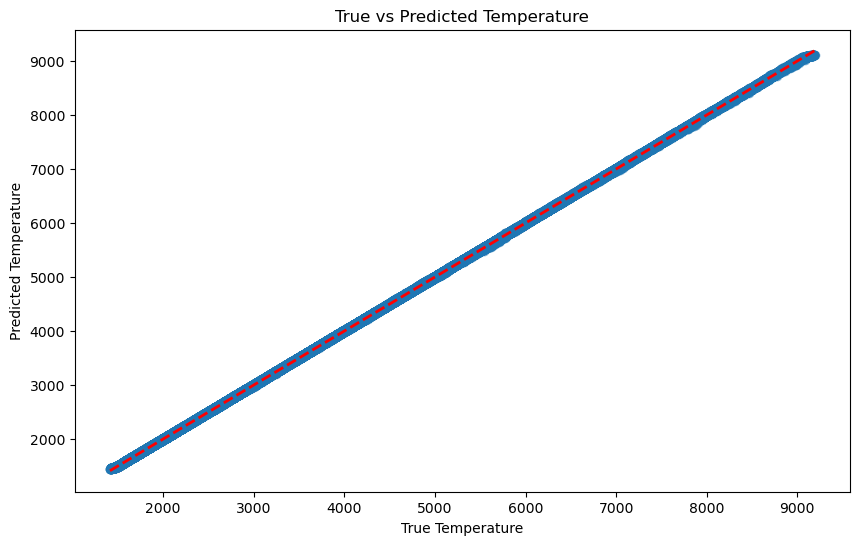

In [10]:
# Load the simulation data and then plo the model performance on the borders and on the inside region.

data_file = '../data/heat_data.csv'

temp1 = pd.read_csv(data_file)

temp2=temp1.copy()

a = temp2.shape[0]

pp1 = np.random.uniform(low=2,high=10,size=a)

temp2['pp1']= pp1
temp2['modtemp'] = temp2['temp']* temp2['pp1']

print(temp2.head(10))
# open scalers

scaler_file = f'../spartan/tr-models/scalers.pkl'


with open(scaler_file, 'rb') as f:
    scaler = pickle.load(f)

cols = ['x','t','pp1','modtemp']

for col in cols:
    temp2[col] = scaler[col].transform(temp2[col].values.reshape(-1, 1))
    

inputs = temp2[['x', 't', 'pp1']].values
inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
temp_val = temp2['modtemp'].values
temp_val = torch.tensor(temp_val, dtype=torch.float32).to(device)

inputs = inputs.view(-1, 3)
# Make predictions
temp_pred = model(inputs)
temp_pred = temp_pred.view(-1, 1)
temp_pred = temp_pred.cpu().detach().numpy()
temp_val = temp_val.cpu().detach().numpy()

# Scale back the predictions
temp_pred_n = scaler['modtemp'].inverse_transform(temp_pred)
temp_val_n = scaler['modtemp'].inverse_transform(temp_val.reshape(-1, 1))

print(temp_val_n[500], temp_pred_n[500])
# Calculate the mean squared error
mse = mean_squared_error(temp_val_n, temp_pred_n)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(temp_val_n, temp_pred_n, alpha=0.5)
plt.plot([temp_val_n.min(), temp_val_n.max()], [temp_val_n.min(), temp_val_n.max()], 'r--', lw=2)
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.title('True vs Predicted Temperature')


